In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import fft, fftpack
import matplotlib.dates as mdates
sns.set(style="darkgrid")
%config IPCompleter.greedy = True
%config Completer.use_jedi = False

In [2]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
%matplotlib inline

In [3]:
data_load_second_interval = 5
#second_interval = 10
minute_interval = 1
#non_reoccuring_number = 500
min_peak_size = 5000

In [4]:
peaks_by_size = pd.read_csv("../../data/peaks/peaks_by_size_extended.csv")
series_start_time = pd.read_csv("../../data/peaks/peak_start_times.csv")
detected_peaks = pd.read_csv("../../data/peaks/detected_peaks.csv")
undetected_peaks = pd.read_csv("../../data/peaks/undetected_peaks.csv")
peaks_by_size_above_min = peaks_by_size[peaks_by_size['count'] > min_peak_size]

In [5]:
data = pd.read_csv(f"../../data/corrected_m2/corrected_data_2_{minute_interval}m_{data_load_second_interval}s.csv")
data['ndt'] = pd.to_datetime(data['ndt'])
data = data[data['hash'].isin(peaks_by_size['hash'])]
data = data.groupby(['hash','ndt']).sum()
data = pd.DataFrame(data, columns=['count'])

In [6]:
dropped_data = data.loc[peaks_by_size[peaks_by_size['count'] <= 5000]['hash']].reset_index().groupby('ndt').sum()

# Undetected peak-series analysis #
This document explores the nature of series where a peak-wasn't detected by the methods defined in the previous document.

In [21]:
len(peaks_by_size_above_min)

864

In [24]:
len(detected_peaks[detected_peaks['fast_detection'] == True])

296

In [25]:
len(peaks_by_size_above_min) - len(detected_peaks[detected_peaks['fast_detection'] == True])

568

In [7]:
detected_peaks = detected_peaks.merge(peaks_by_size, on='hash')
undetected_peaks = undetected_peaks.merge(peaks_by_size, on='hash')

In [6]:
detected_peaks.describe()

Unnamed: 0_x   size_rank    total_time  Unnamed: 0_y         count  \
count    833.000000  833.000000    833.000000    833.000000    833.000000   
mean     422.971188  422.971188    128.147659    422.971188   9725.471989   
std      248.220826  248.220826   1959.605730    248.220826   5300.249505   
min        0.000000    0.000000      1.833333      0.000000   5005.000000   
25%      208.000000  208.000000     10.666667    208.000000   6273.000000   
50%      420.000000  420.000000     18.083333    420.000000   7910.500000   
75%      635.000000  635.000000     46.916667    635.000000  11318.000000   
max      863.000000  863.000000  55790.333333    863.000000  48215.500000   

             mean      median          1q          3q         min         max  \
count  833.000000  833.000000  833.000000  833.000000  833.000000  833.000000   
mean     2.192587    1.522809    1.028211    2.841537    0.893157   12.661465   
std      1.000483    0.932562    0.272071    1.622208    0.208947    6.741495   
min      0.950078    1.000000    0.500000    1.000000    0.333333    5.000000   
25%      1.485828    1.000000    1.000000    2.000000    1.000000    9.000000   
50%      1.919788    1.000000    1.000000    2.000000    1.000000   11.000000   
75%      2.588076    2.000000    1.000000    3.000000    1.000000   15.000000   
max      9.188762    9.000000    5.000000   15.000000    1.000000   80.000000   

           lifespan  
count    833.000000  
mean   35692.949380  
std    20961.177698  
min      546.583333  
25%    16938.250000  
50%    34543.666667  
75%    53900.833333  
max    76122.666667

In [7]:
undetected_peaks.describe()

Unnamed: 0_x   size_rank  total_time  Unnamed: 0_y        count  \
count     31.000000   31.000000   31.000000     31.000000    31.000000   
mean     660.677419  660.677419   -0.040323    660.677419  6220.381720   
std      162.927261  162.927261    0.042333    162.927261  1243.976946   
min      293.000000  293.000000   -0.083333    293.000000  5011.000000   
25%      561.000000  561.000000   -0.083333    561.000000  5462.000000   
50%      722.000000  722.000000    0.000000    722.000000  5692.000000   
75%      761.000000  761.000000    0.000000    761.000000  6658.750000   
max      862.000000  862.000000    0.000000    862.000000  9685.500000   

            mean  median         1q    3q        min        max      lifespan  
count  31.000000    31.0  31.000000  31.0  31.000000  31.000000     31.000000  
mean    1.101840     1.0   0.983871   1.0   0.677419   4.806452  52079.739247  
std     0.104039     0.0   0.089803   0.0   0.304094   2.023518  23136.927040  
min     0.966660     1.0   0.500000   1.0   0.333333   2.000000   1138.166667  
25%     0.988547     1.0   1.000000   1.0   0.333333   3.000000  37275.625000  
50%     1.110024     1.0   1.000000   1.0   0.500000   5.000000  52923.333333  
75%     1.157758     1.0   1.000000   1.0   1.000000   6.000000  75815.291667  
max     1.285875     1.0   1.000000   1.0   1.000000   9.000000  76232.750000

In [29]:
peaks_by_size[peaks_by_size['count'] <= min_peak_size].describe()

Unnamed: 0         count          mean        median            1q  \
count  11916.000000  11916.000000  11916.000000  11916.000000  11916.000000   
mean    6821.500000    887.096719      1.195279      1.058451      1.002297   
std     3439.997238   1015.368422      0.806259      0.691416      0.200676   
min      864.000000    101.000000      0.774401      1.000000      0.500000   
25%     3842.750000    198.000000      1.016538      1.000000      1.000000   
50%     6821.500000    461.000000      1.054892      1.000000      1.000000   
75%     9800.250000   1142.000000      1.169762      1.000000      1.000000   
max    12779.000000   4999.000000     58.824561     61.000000     15.000000   

                 3q           min           max      lifespan  
count  11916.000000  11916.000000  11916.000000  11916.000000  
mean       1.210012      0.934794      3.904414  33262.557122  
std        1.322275      0.176933      3.896049  24549.665427  
min        1.000000      0.333333      1.000000      2.333333  
25%        1.000000      1.000000      2.000000   9462.250000  
50%        1.000000      1.000000      3.000000  29554.500000  
75%        1.000000      1.000000      5.000000  54254.750000  
max       89.000000      6.000000    154.000000  76241.000000

Text(0.5, 0.98, 'Boxplots for Mean/Max/Lifespan (in minutes) of undetected-peak series')

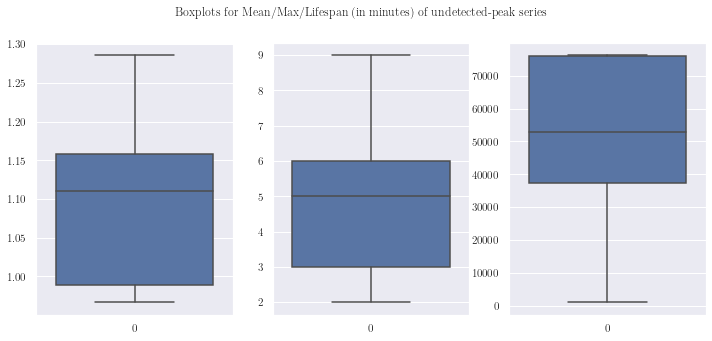

In [21]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(12, 5)
sns.boxplot(data=undetected_peaks['mean'], ax=ax[0])
sns.boxplot(data=undetected_peaks['max'], ax=ax[1])
sns.boxplot(data=undetected_peaks['lifespan'], ax=ax[2])
fig.suptitle("Boxplots for Mean/Max/Lifespan (in minutes) of undetected-peak series")

In [22]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(12, 5)
sns.boxplot(data=detected_peaks['mean'], ax=ax[0])
sns.boxplot(data=detected_peaks['max'], ax=ax[1])
sns.boxplot(data=detected_peaks['lifespan'], ax=ax[2])
fig.suptitle("Boxplots for Mean/Max/Lifespan (in minutes) of detected-peak series")

Text(0.5, 0.98, 'Boxplots for Mean/Max/Lifespan (in minutes) of detected-peak series')

In [10]:
detected_peaks['median'].value_counts()

1.0    520
2.0    249
3.0     40
5.0      8
4.0      6
7.0      3
6.0      3
9.0      2
1.5      1
8.0      1
Name: median, dtype: int64

In [11]:
undetected_peaks['median'].value_counts()

1.0    31
Name: median, dtype: int64

Comparing the median among the groups, it can be observed that with the undetected-peak series, the median is exclusively ones, this is less significantly less common in the detected-peak series.

Text(0.5, 0.98, 'Comparing the lifespans of detected/undetected-peak series.')

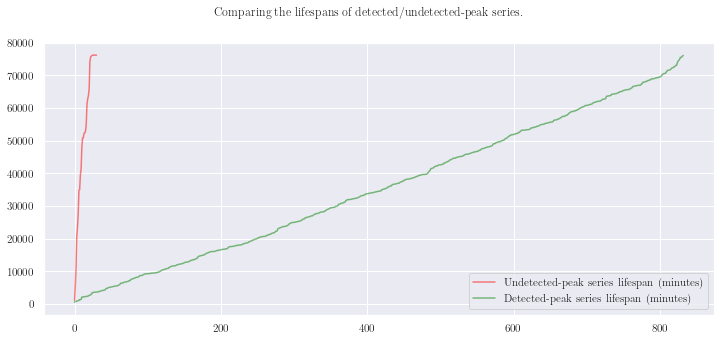

In [23]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 5)

#ax.set_yscale('log')
undetected_peaks['lifespan'].sort_values().plot(use_index=False, ax=ax, alpha=0.5, color='red')
detected_peaks['lifespan'].sort_values().plot(use_index=False, ax=ax, alpha=0.5, color='green')
ax.legend(['Undetected-peak series lifespan (minutes)','Detected-peak series lifespan (minutes)'])
fig.suptitle("Comparing the lifespans of detected/undetected-peak series.")

<AxesSubplot:xlabel='count', ylabel='lifespan'>

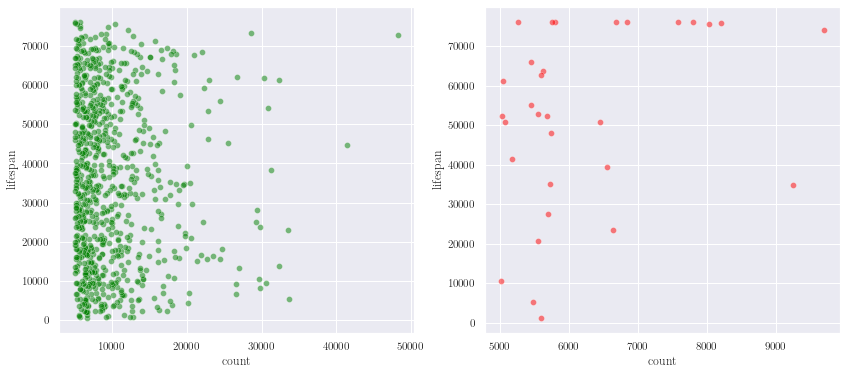

In [24]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 6)
sns.scatterplot(data=detected_peaks, x='count',y='lifespan',ax=ax[0], alpha=0.5, color='green')
sns.scatterplot(data=undetected_peaks, x='count',y='lifespan',ax=ax[1], alpha=0.5, color='red')

Text(0.5, 0.98, 'Comparing the means of requests for detected/undetected-peak series. (Log scale)')

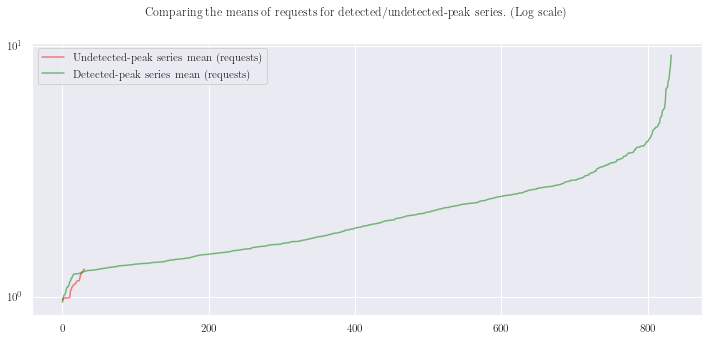

In [25]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 5)

ax.set_yscale('log')
undetected_peaks['mean'].sort_values().plot(use_index=False, ax=ax, alpha=0.5, color='red')
detected_peaks['mean'].sort_values().plot(use_index=False, ax=ax, alpha=0.5, color='green')
ax.legend(['Undetected-peak series mean (requests)','Detected-peak series mean (requests)'])
fig.suptitle("Comparing the means of requests for detected/undetected-peak series. (Log scale)")

Text(0.5, 0.98, 'Comparing the largest requests per-series for detected/undetected-peak series.')

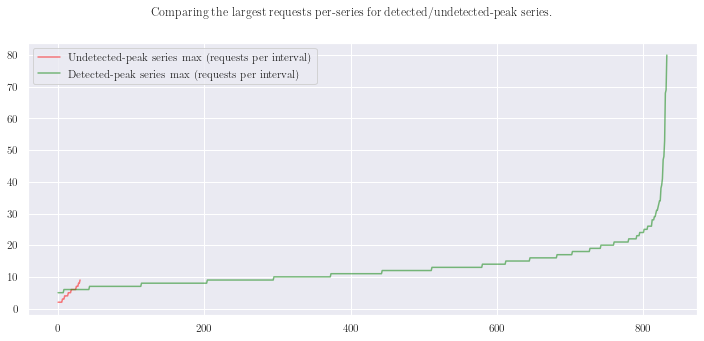

In [26]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 5)
#ax.set_yscale('log')
undetected_peaks['max'].sort_values().plot(use_index=False, ax=ax, alpha=0.5, color='red')
detected_peaks['max'].sort_values().plot(use_index=False, ax=ax, alpha=0.5, color='green')
ax.legend(['Undetected-peak series max (requests per interval)','Detected-peak series  max (requests per interval)'])
fig.suptitle("Comparing the largest requests per-series for detected/undetected-peak series.")

In [9]:
raw_data = data.reset_index()
undetected_data = raw_data[raw_data['hash'].isin(undetected_peaks['hash'])].groupby('ndt').sum().resample('1H').sum().fillna(0)
detected_data =  raw_data[raw_data['hash'].isin(detected_peaks['hash'])].groupby('ndt').sum().resample('1H').sum().fillna(0)

In [17]:
detected_data.sum() / undetected_data.sum()

count    42.019737
dtype: float64

In [18]:
detected_data.sum() 

count    8100901.0
dtype: float64

In [19]:
undetected_data.sum() 

count    192788.0
dtype: float64

In [13]:
detected_data.sum() + dropped_data.sum() + undetected_data.sum()

count    1.886164e+07
dtype: float64

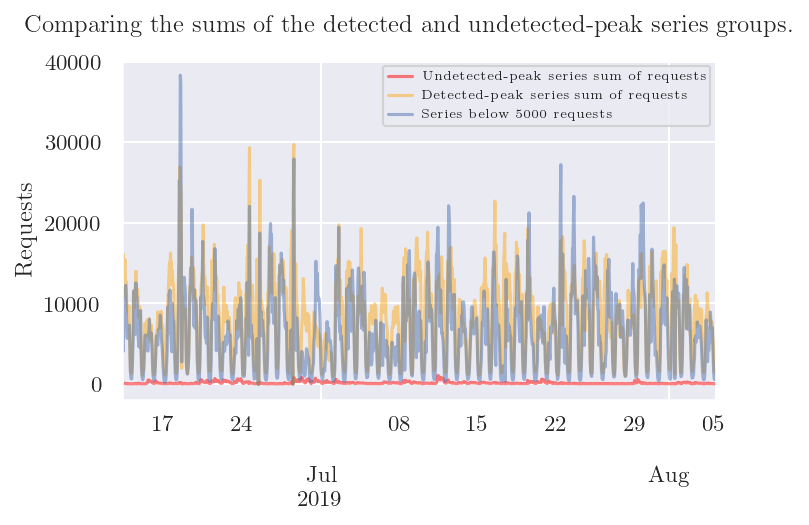

In [19]:
fig, ax = plt.subplots(1, 1, dpi=150)
fig.set_size_inches(w=5.10686, h=3)


undetected_data.plot(ax=ax, alpha=0.5, color='red')
dropped_data.resample('1H').sum().fillna(0).plot(ax=ax, alpha=0.45, color='orange')
detected_data.plot(ax=ax, alpha=0.5)

ax.set_xlabel("")
ax.set_ylabel("Requests")
ax.legend(['Undetected-peak series sum of requests','Detected-peak series sum of requests', 'Series below 5000 requests'], fontsize="xx-small")
fig.suptitle("Comparing the sums of the detected and undetected-peak series groups.")
fig.savefig('../../plots/text-plots/7-peak-groups-sums.pgf')